In [1]:
import matplotlib.pyplot as plt
import ds_functions as ds
import scipy as sc
import numpy as np
import pandas as pd

original: pd.DataFrame = pd.read_csv('qsar_oral_toxicity.csv')

X_original = original.drop('Result' , axis=1)
Y_original = original['Result']

#Binary data doesn't need any scaling

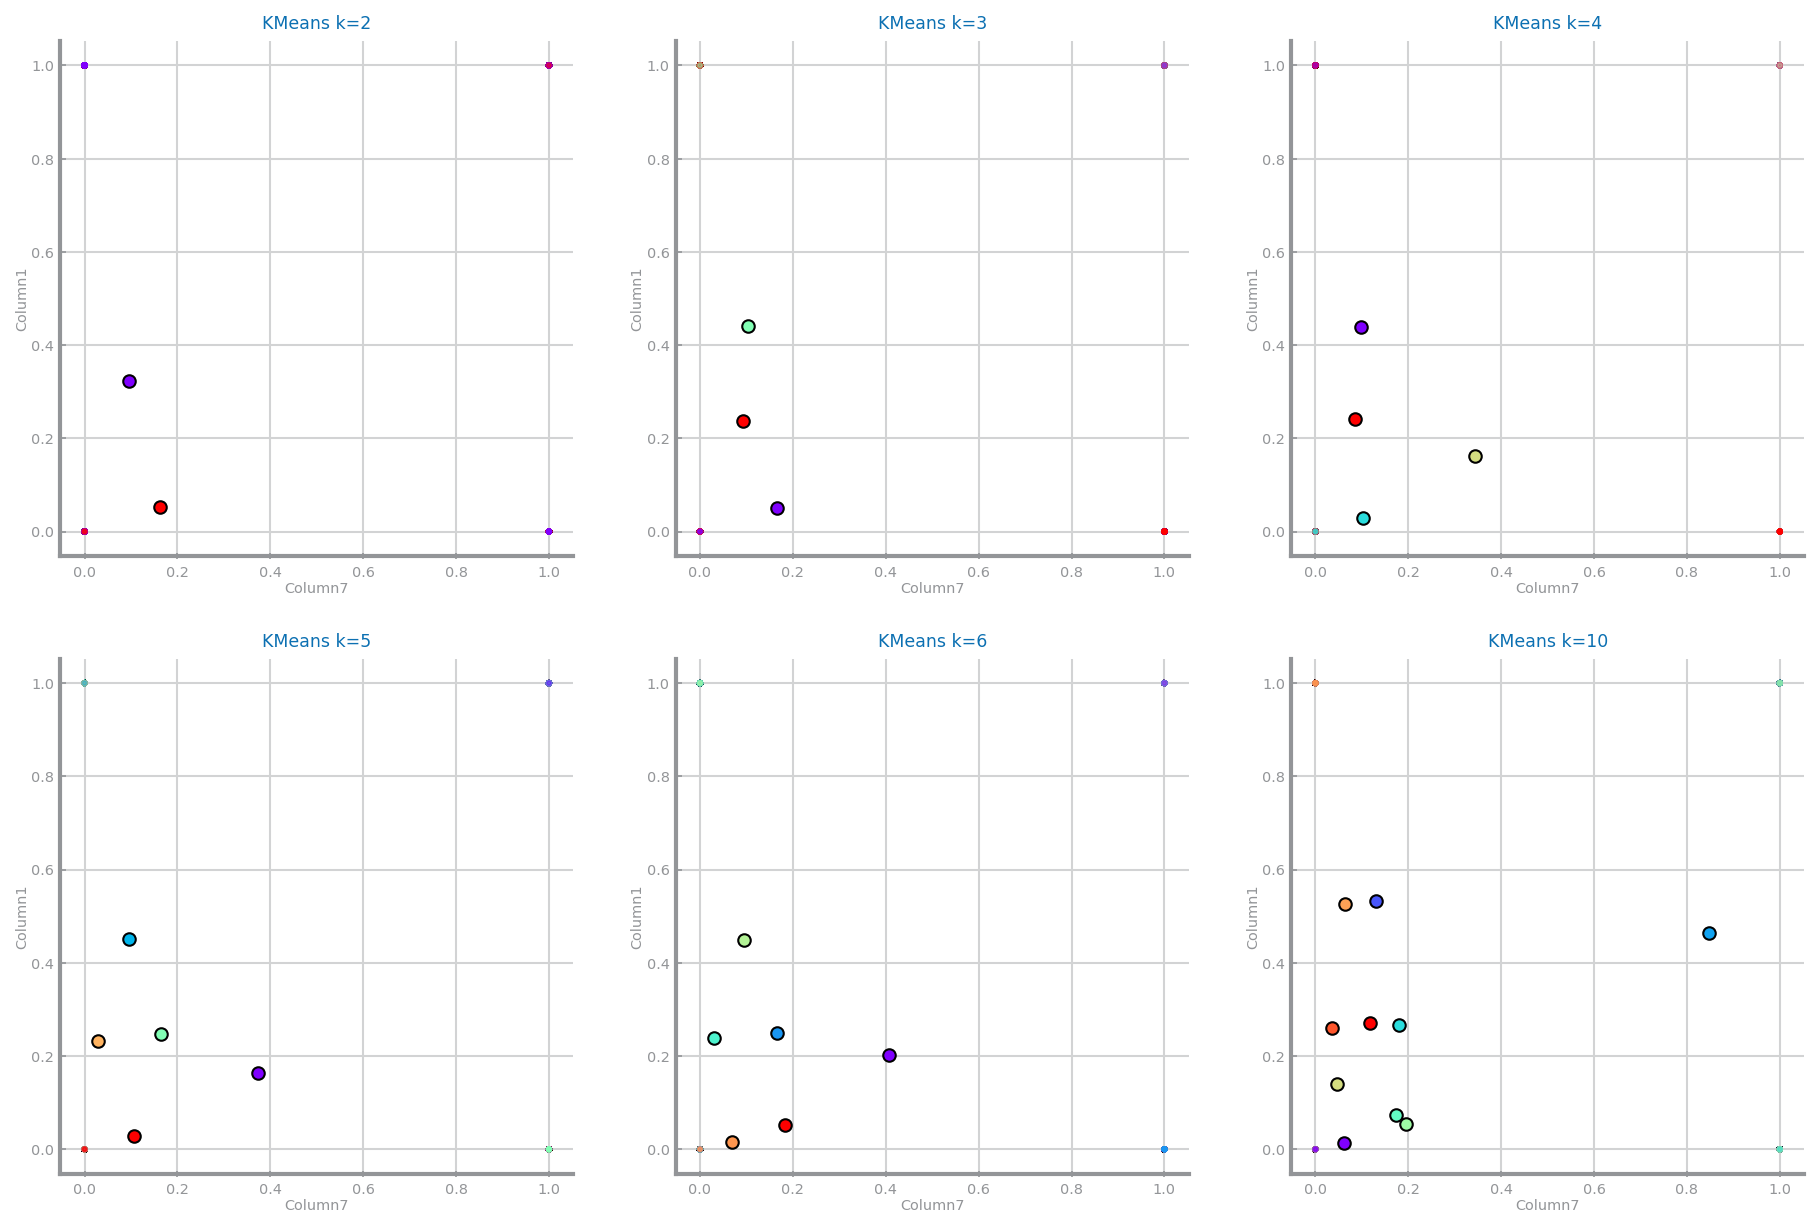

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

v1 =0
v2 =6

N_CLUSTERS = [2, 3, 4, 5 , 6 , 10]
rows, cols = ds.choose_grid(len(N_CLUSTERS))

mse: list = []
sc: list = []
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(X_original)
    mse.append(estimator.inertia_)
    sc.append(silhouette_score(X_original, estimator.labels_))
    ds.plot_clusters(X_original, v2, v1, estimator.labels_.astype(float), estimator.cluster_centers_, k,
                     f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

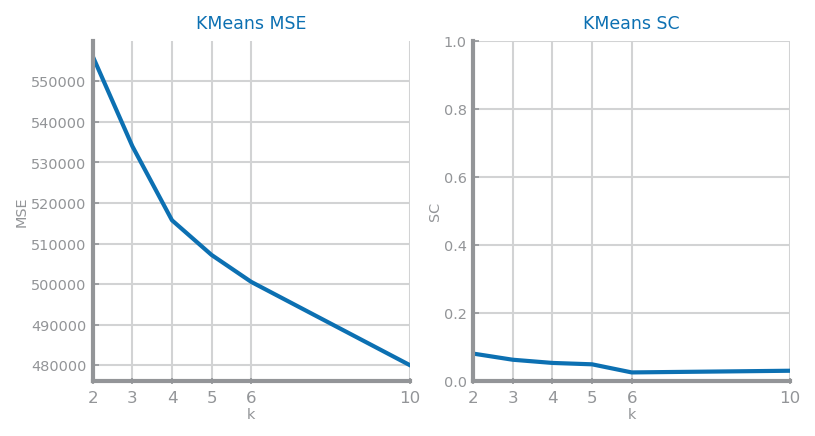

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

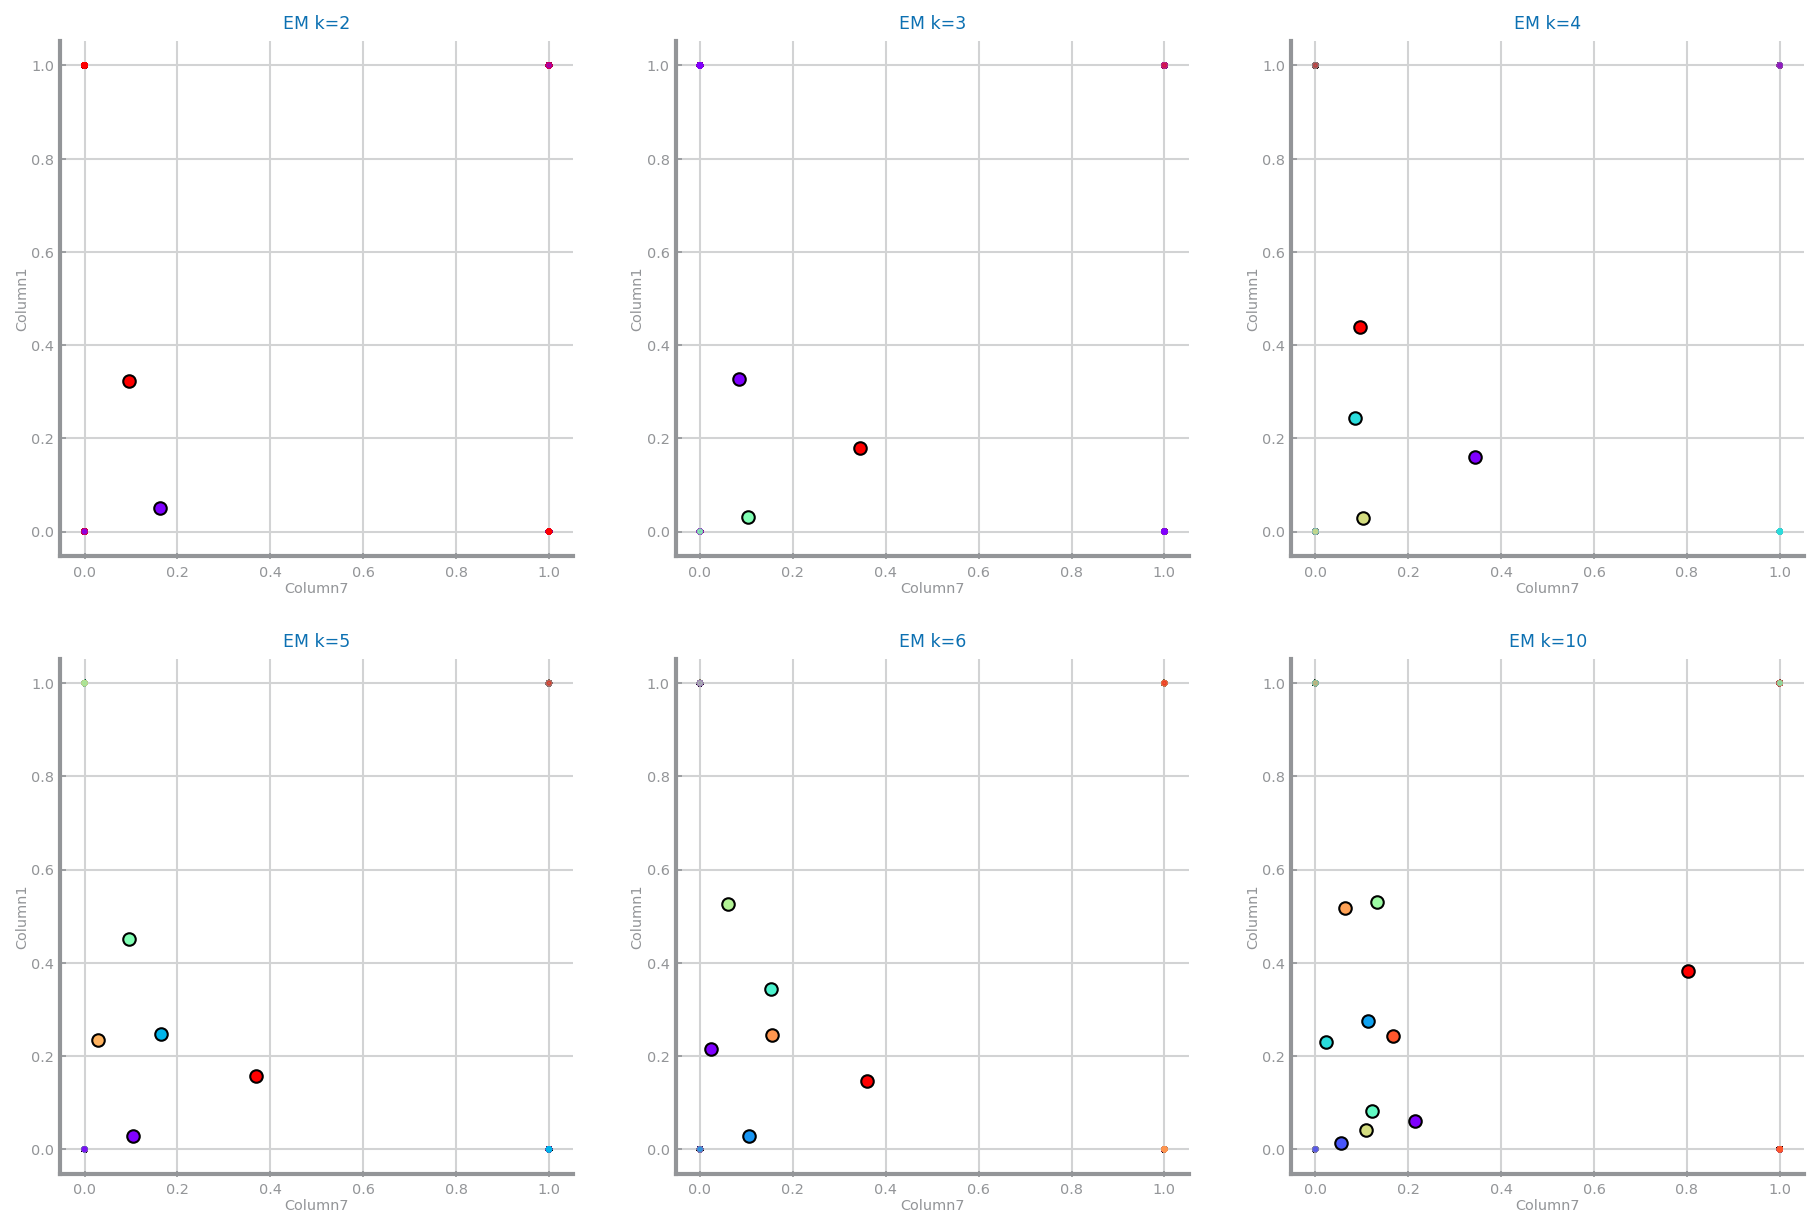

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
mse: list = []
sc: list = []
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = GaussianMixture(n_components=k)
    estimator.fit(X_original)
    labels = estimator.predict(X_original)
    mse.append(ds.compute_mse(X_original.values, labels, estimator.means_))
    sc.append(silhouette_score(X_original, labels))
    ds.plot_clusters(X_original, v2, v1, labels.astype(float), estimator.means_, k,
                     f'EM k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

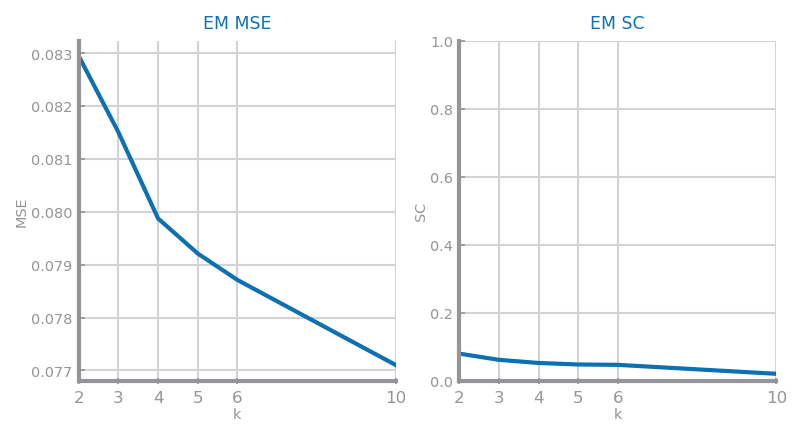

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='EM MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='EM SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

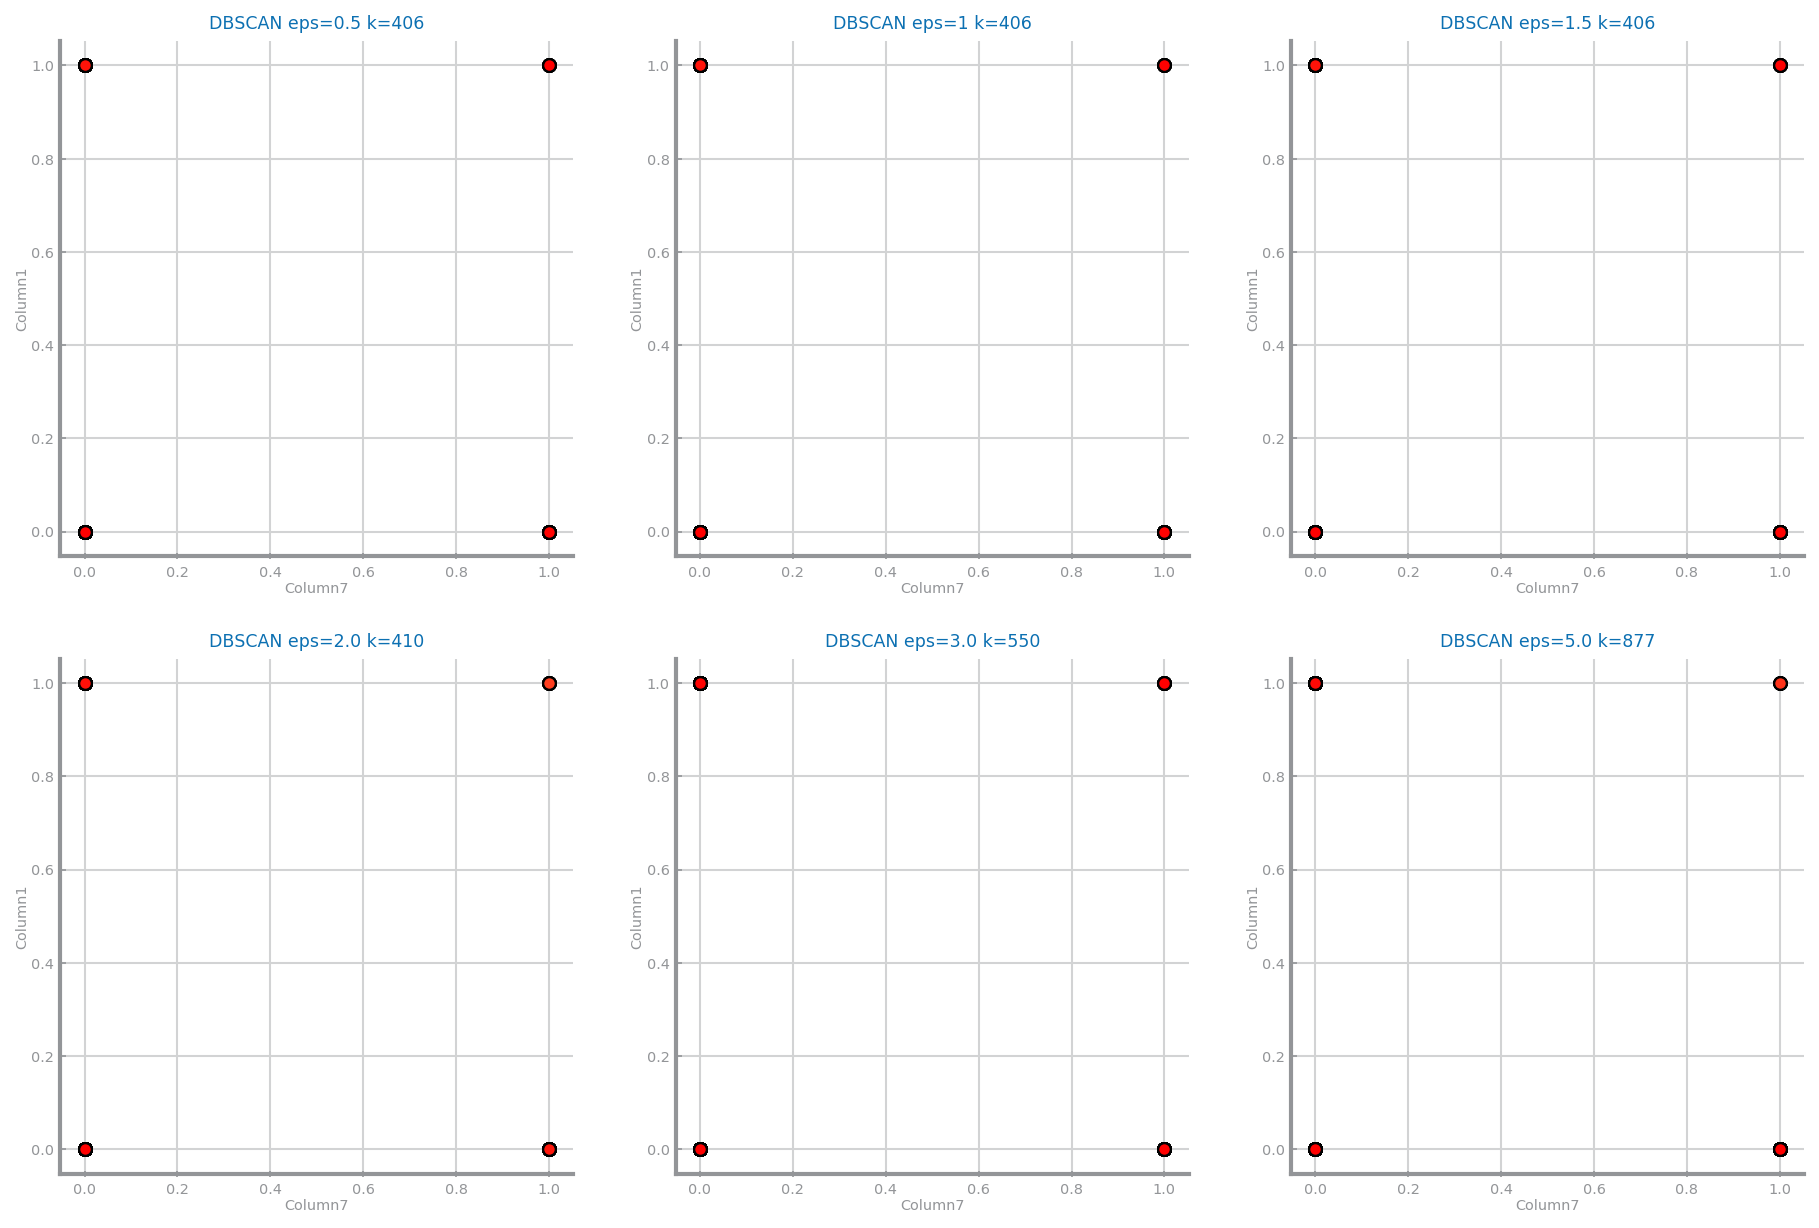

In [6]:
from sklearn.cluster import DBSCAN

EPS = [0.5, 1, 1.5, 2.0, 3.0, 5.0]
mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(EPS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(X_original)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(X_original, labels)
        mse.append(ds.compute_mse(X_original.values, labels, centers))
        sc.append(silhouette_score(X_original, labels))
        ds.plot_clusters(X_original, v2, v1, labels.astype(float), estimator.components_, k,
                         f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
plt.show()

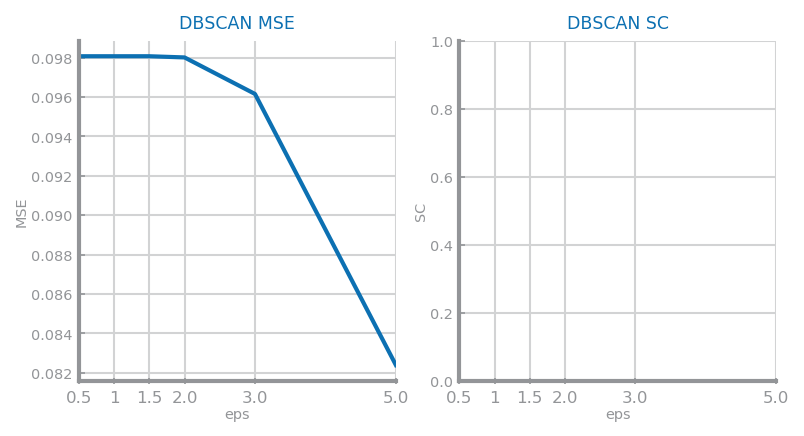

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(EPS, mse, title='DBSCAN MSE', xlabel='eps', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(EPS, sc, title='DBSCAN SC', xlabel='eps', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

In [8]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
distances = []
for m in METRICS:
    dist = np.mean(np.mean(squareform(pdist(X_original.values, metric=m))))
    distances.append(dist)

print('AVG distances among records', distances)
distances[0] *= 0.6
distances[1] = 1.895
distances[2] *= 0.6
distances[3] *= 0.1
distances[4] *= 0.15
print('CHOSEN EPS', distances)

AVG distances among records [11.441172559146954, 134.88438321707076, 0.9998726131412976, 0.7082288366972024, 0.8318665315949874]
CHOSEN EPS [6.8647035354881725, 1.895, 0.5999235678847785, 0.07082288366972024, 0.12477997973924809]


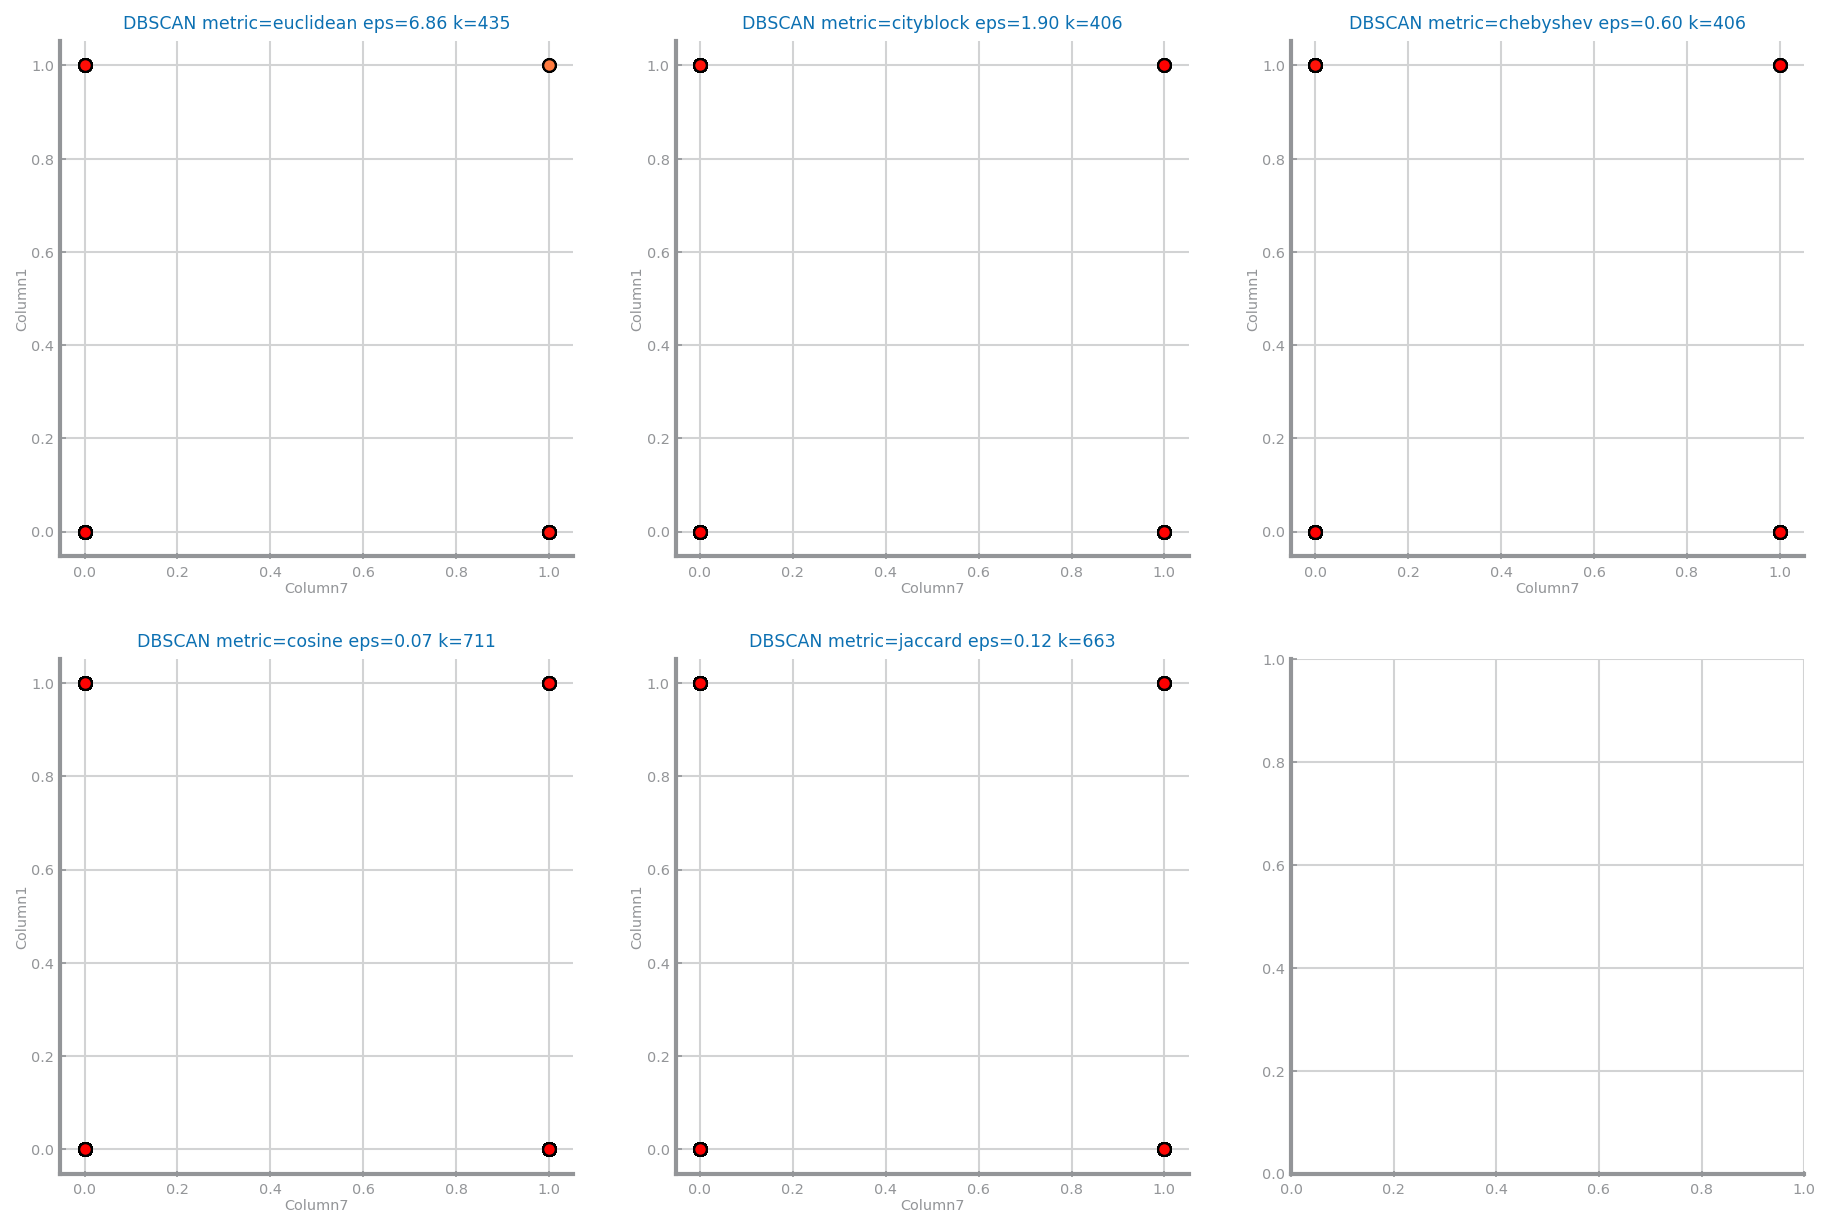

In [9]:
mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(METRICS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    estimator.fit(X_original)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = ds.compute_centroids(X_original, labels)
        mse.append(ds.compute_mse(X_original.values, labels, centers))
        sc.append(silhouette_score(X_original, labels))
        ds.plot_clusters(X_original, v2, v1, labels.astype(float), estimator.components_, k,
                         f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

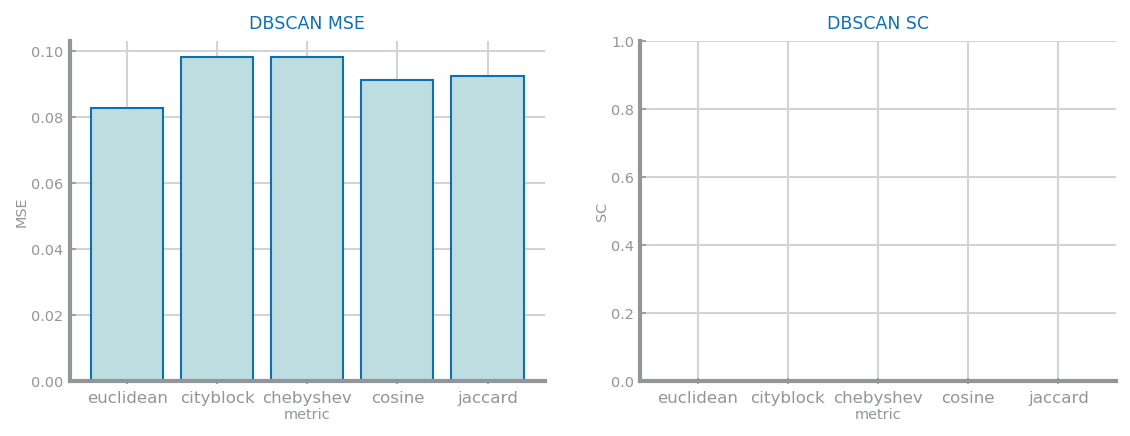

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), squeeze=False)
ds.bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
ds.bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

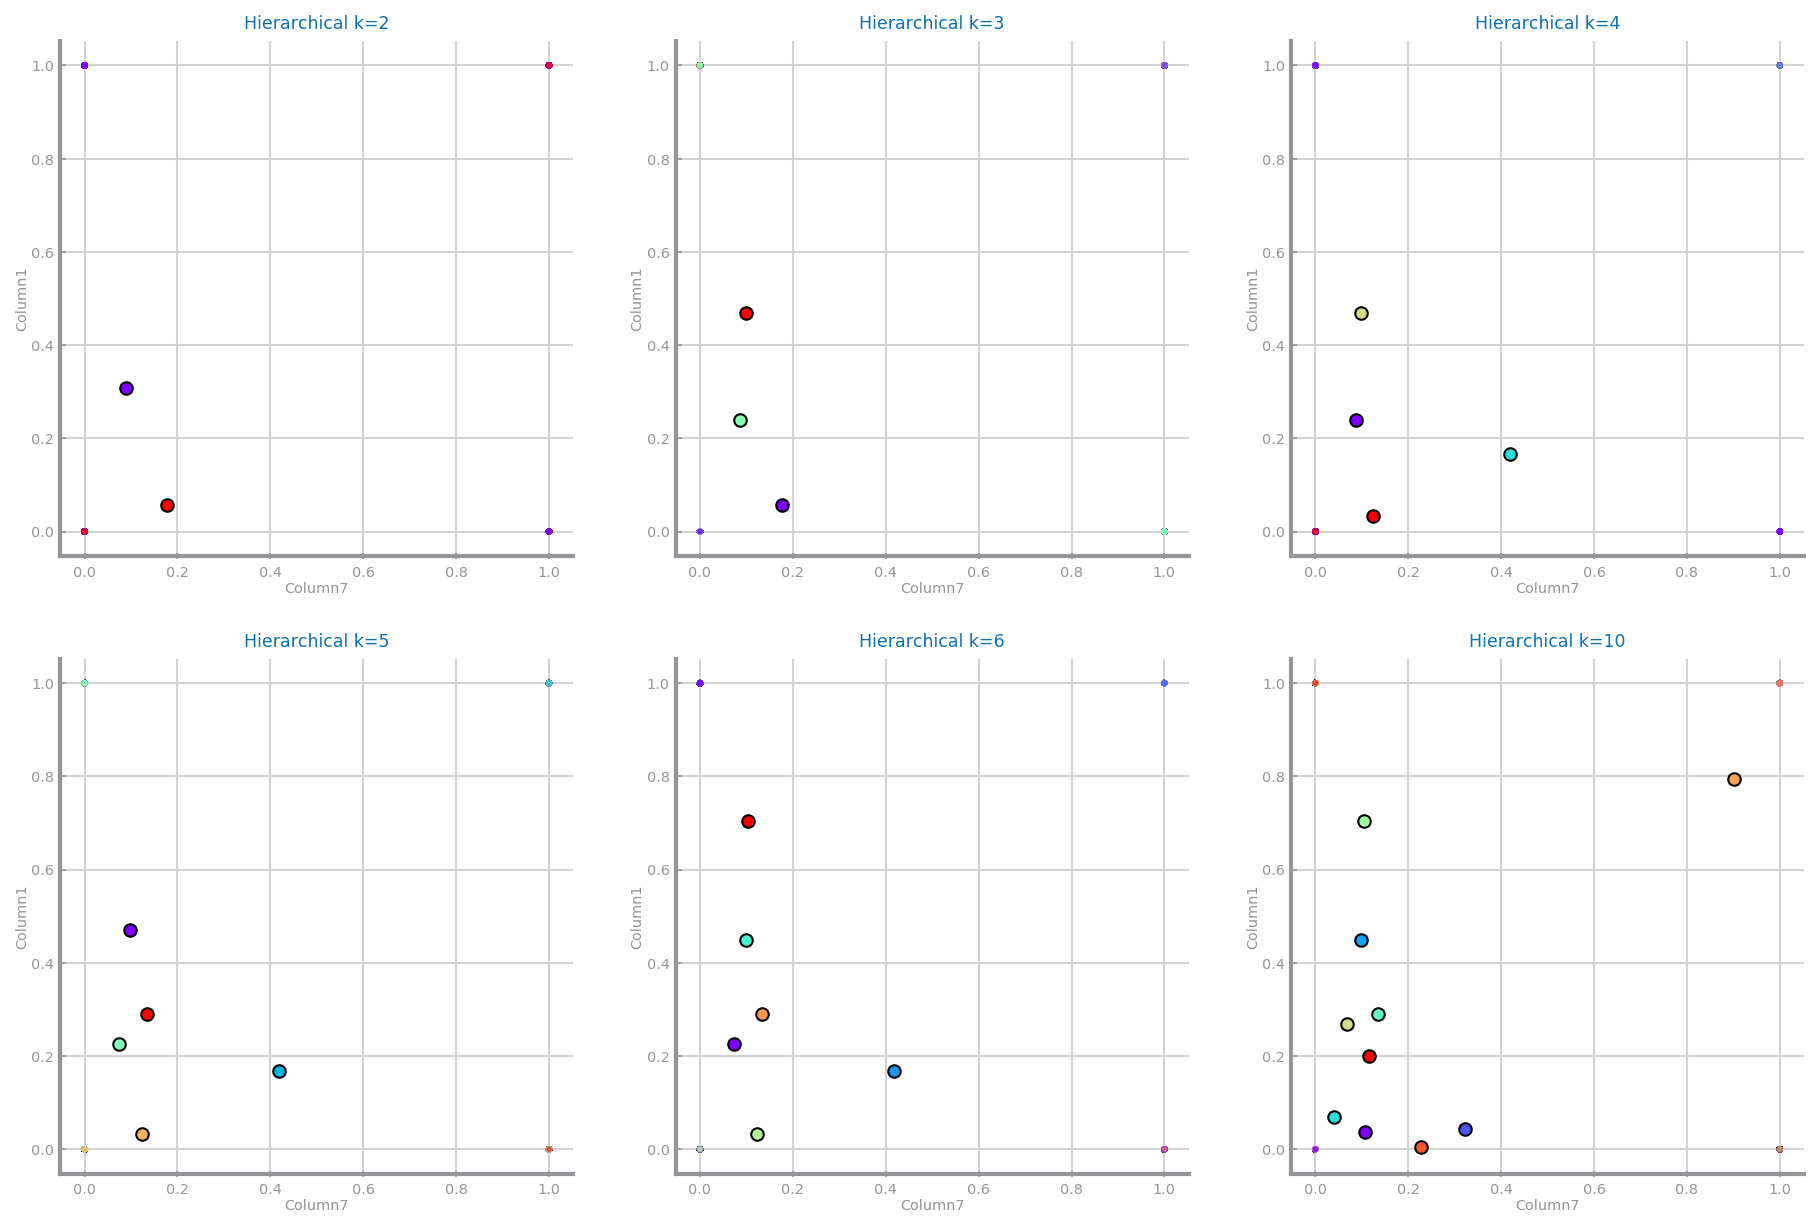

In [11]:
from sklearn.cluster import AgglomerativeClustering

mse: list = []
sc: list = []
rows, cols = ds.choose_grid(len(N_CLUSTERS))
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = AgglomerativeClustering(n_clusters=k)
    estimator.fit(X_original)
    labels = estimator.labels_
    centers = ds.compute_centroids(X_original, labels)
    mse.append(ds.compute_mse(X_original.values, labels, centers))
    sc.append(silhouette_score(X_original, labels))
    ds.plot_clusters(X_original, v2, v1, labels, centers, k,
                     f'Hierarchical k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
plt.show()

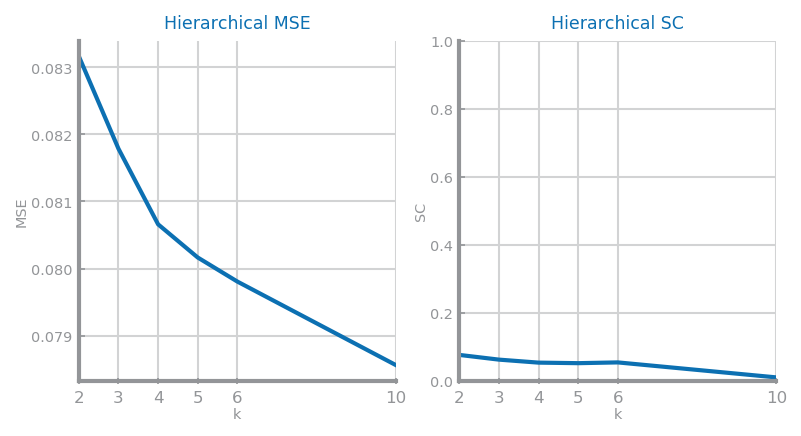

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.plot_line(N_CLUSTERS, mse, title='Hierarchical MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
ds.plot_line(N_CLUSTERS, sc, title='Hierarchical SC', xlabel='k', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()

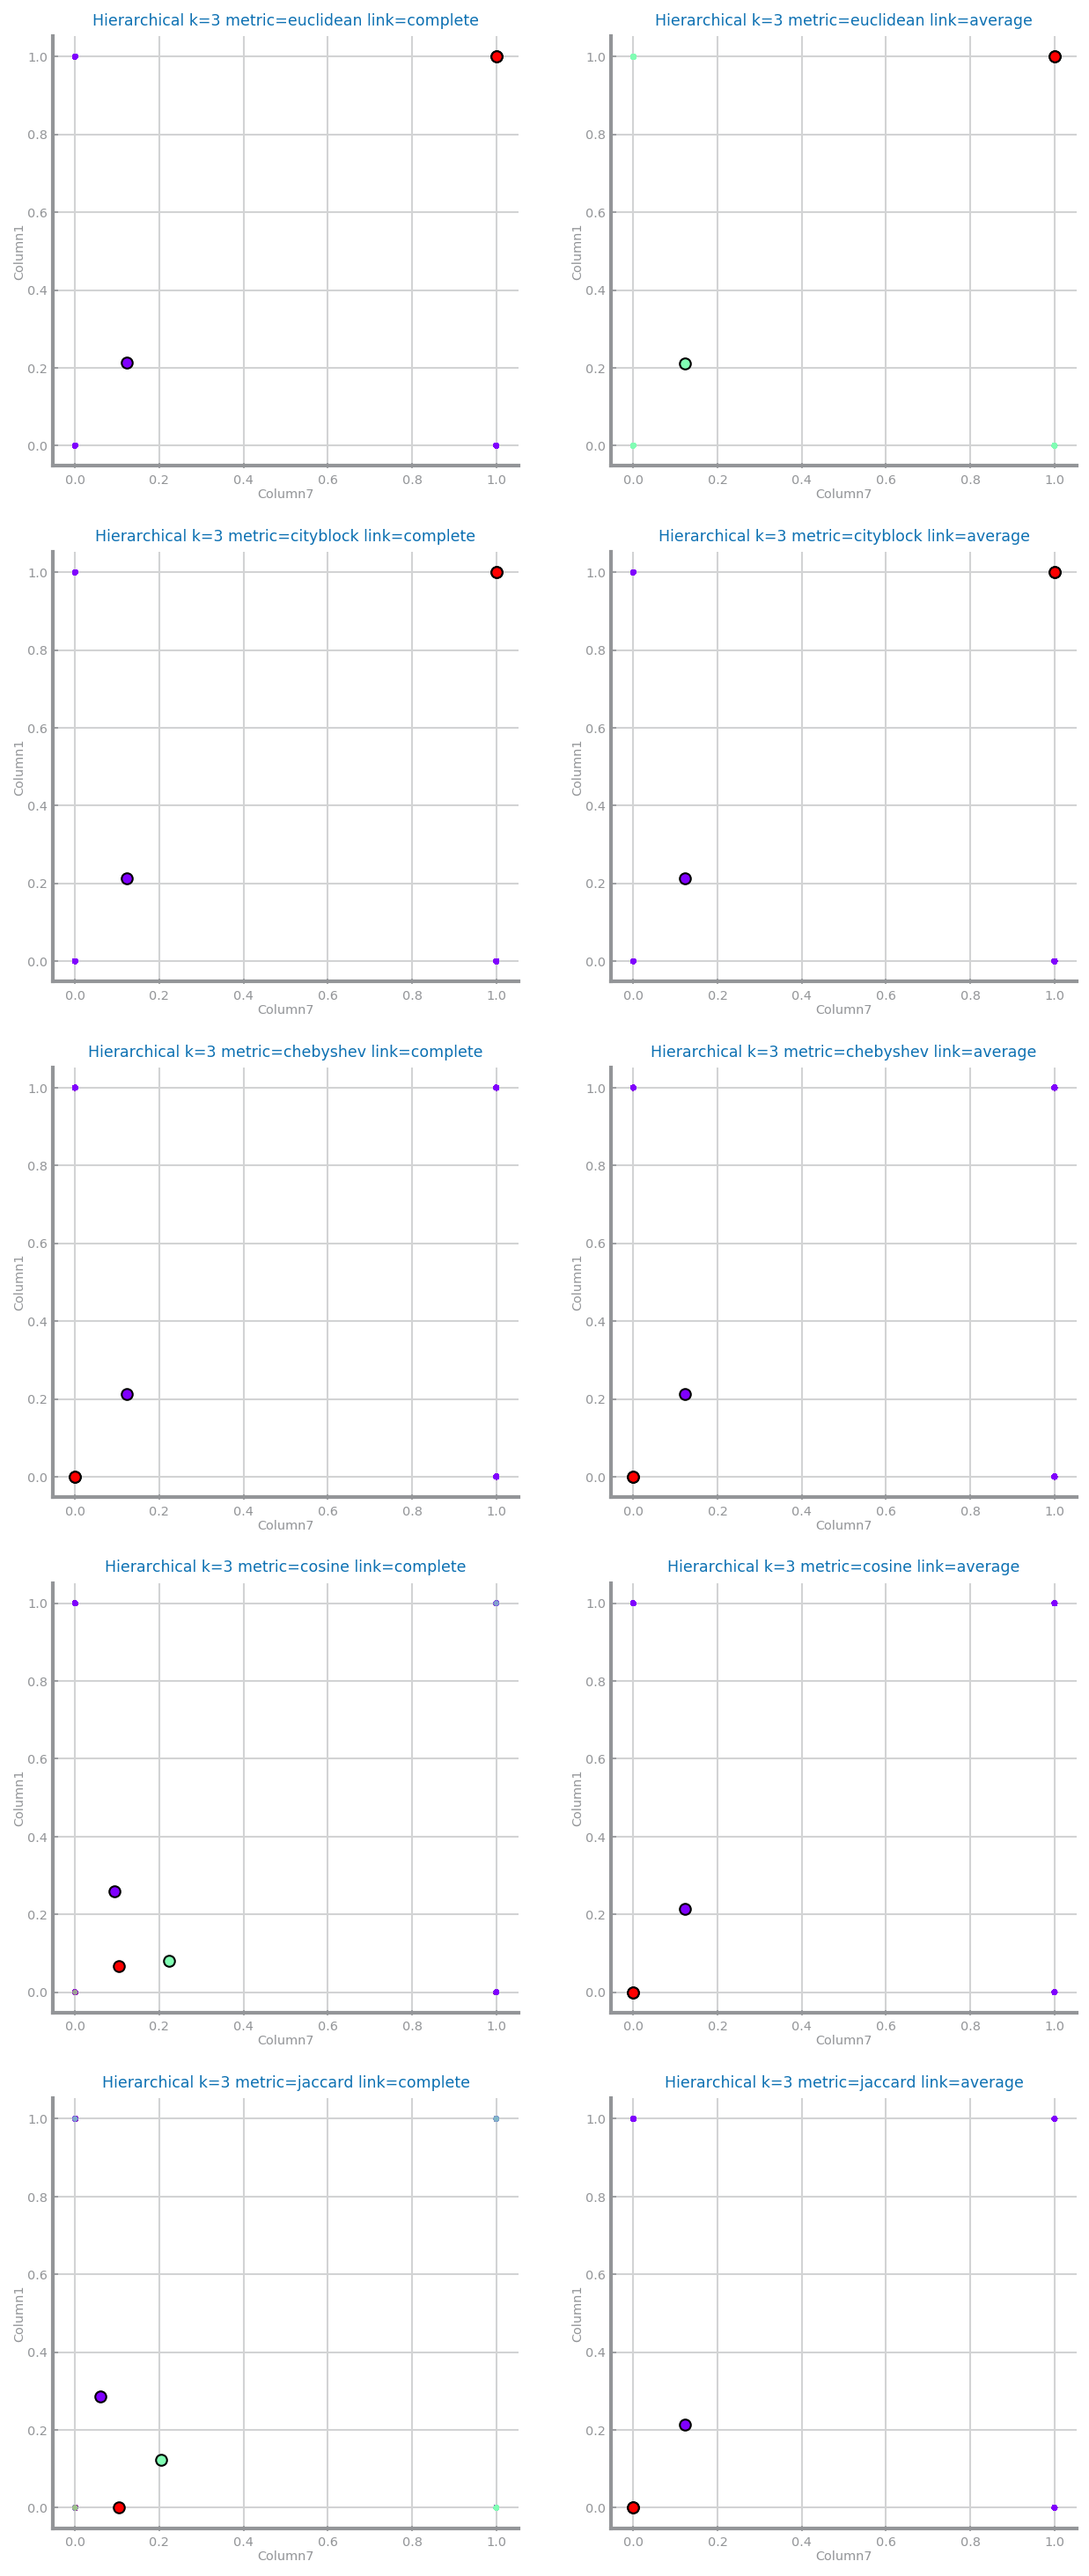

In [13]:
METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
LINKS = ['complete', 'average']
k = 3
values_mse = {}
values_sc = {}
rows = len(METRICS)
cols = len(LINKS)
_, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
for i in range(len(METRICS)):
    mse: list = []
    sc: list = []
    m = METRICS[i]
    for j in range(len(LINKS)):
        link = LINKS[j]
        estimator = AgglomerativeClustering(n_clusters=k, linkage=link, affinity=m )
        estimator.fit(X_original)
        labels = estimator.labels_
        centers = ds.compute_centroids(X_original, labels)
        mse.append(ds.compute_mse(X_original.values, labels, centers))
        sc.append(silhouette_score(X_original, labels))
        ds.plot_clusters(X_original, v2, v1, labels, centers, k,
                         f'Hierarchical k={k} metric={m} link={link}', ax=axs[i,j])
    values_mse[m] = mse
    values_sc[m] = sc
plt.show()

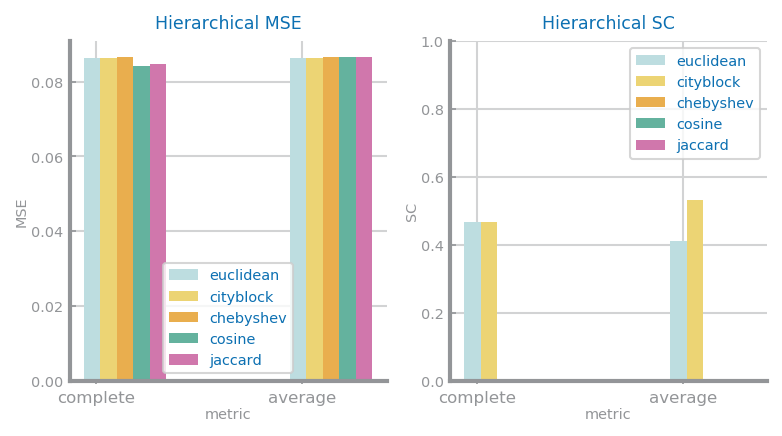

In [14]:
_, ax = plt.subplots(1, 2, figsize=(6, 3), squeeze=False)
ds.multiple_bar_chart(LINKS, values_mse, title=f'Hierarchical MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
ds.multiple_bar_chart(LINKS, values_sc, title=f'Hierarchical SC', xlabel='metric', ylabel='SC', ax=ax[0, 1], percentage=True)
plt.show()